###**Projekt af Thor Vestergaard Christiansen (s173949) og August Leander Høeg (s173944)**

Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import random

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import gaussian_blur
from torchvision.transforms.functional import rotate
import torch
import pickle
cuda = torch.cuda.is_available()
#cuda = False

try:
    from plotting_CIFAR10 import plot_autoencoder_stats
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`.           \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer           \n---------------------------------------------")
    print(ex)

from scipy.ndimage import gaussian_filter, convolve, gaussian_laplace, laplace


If using Colab, you may need to upload `plotting.py`.           
In the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer           
---------------------------------------------
No module named 'plotting_CIFAR10'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec  7 20:42:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    44W / 250W |   2303MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Image noise functions

In [ ]:
def add_noise_and_clip_data(MM):
    data = MM
    noise = np.random.normal(loc=0.0, scale=0.3, size=data[0].shape)
    for i in range(len(data[:])):
        data[i] = data[i] + noise
        data[i] = np.clip(data[i], -1., 1.)
    return data


def gaussian_noise(data, strength):
    noise = np.random.normal(loc=0.0, scale=strength, size=data.shape)
    data = data + noise
    data = np.clip(data, -1., 1.)
    return data


def salt_and_pepper_noise(data, prob_salt, prob_peper):
    noise_pepper = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob_peper, 1. - prob_peper])
    noise_salt = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob_salt, 1. - prob_salt])
    # Salt = np.multiply(noise,(-1.)*np.ones((data.shape[1],data.shape[2])))
    P = np.zeros(data.shape)
    P[0][:][:] = noise_pepper
    P[1][:][:] = noise_pepper
    P[2][:][:] = noise_pepper
    data = np.multiply(data, P)
    data = data + (-random.uniform(0, 1)) * (np.ones(data.shape) - P)
    P[0][:][:] = noise_salt
    P[1][:][:] = noise_salt
    P[2][:][:] = noise_salt
    data = np.multiply(data, P)
    data = data + (random.uniform(0, 1)) * (np.ones(data.shape) - P)
    return data

def salt_and_pepper_noise_deterministic(data, prob_salt, prob_peper):
    noise_pepper = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob_peper, 1. - prob_peper])
    noise_salt = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob_salt, 1. - prob_salt])
    # Salt = np.multiply(noise,(-1.)*np.ones((data.shape[1],data.shape[2])))
    P = np.zeros(data.shape)
    P[0][:][:] = noise_pepper
    P[1][:][:] = noise_pepper
    P[2][:][:] = noise_pepper
    data = np.multiply(data, P)
    data = data + (-0.4) * (np.ones(data.shape) - P)
    P[0][:][:] = noise_salt
    P[1][:][:] = noise_salt
    P[2][:][:] = noise_salt
    data = np.multiply(data, P)
    data = data + (0.5) * (np.ones(data.shape) - P)
    return data

def grainy_images(data, prob):
    noise_pepper = np.random.choice([0, 1], size=(data.shape[1], data.shape[2]), p=[prob, 1. - prob])
    P = np.zeros(data.shape)
    P[0][:][:] = noise_pepper
    P[1][:][:] = noise_pepper
    P[2][:][:] = noise_pepper
    # data = np.multiply(data,P)
    M = (random.uniform(0, 1) / 4.) * (np.ones(data.shape) - 2 * P)
    # print("M = ", M)
    data = data + M
    data = np.clip(data, -1., 1.)
    return data


def overexposure(data, value):
    data = data + value * np.ones(data.shape)
    data = np.clip(data, -1., 1.)
    return data


def underexposure(data, value):
    data = data - value * np.ones(data.shape)
    data = np.clip(data, -1., 1.)
    return data


def gaussian_grain(data, strength1, strength2):
    noise_pepper = torch.abs(torch.normal(mean=0, std=strength1, size=(data.shape[1], data.shape[2])))
    noise_salt = torch.abs(torch.normal(mean=0, std=strength2, size=(data.shape[1], data.shape[2])))
    data[0, :, :] += noise_salt
    data[1, :, :] += noise_salt
    data[2, :, :] += noise_salt
    data[0, :, :] -= noise_pepper
    data[1, :, :] -= noise_pepper
    data[2, :, :] -= noise_pepper
    data = np.clip(data, -1., 1.)
    return data

def gauss_2D(n,m,t=1.0):

    kernel = np.zeros((n, m))
    s = np.sqrt(t)

    if n >= m:
        xx = np.linspace(-(n-1)/2, (n-1)/2, n)
    else:
        xx = np.linspace(-(m-1)/2, (m-1)/2, m)

    for i, x in enumerate(xx):
        if n == 1:
            kernel[0, i] = (1/(np.sqrt(2*t*np.pi)))*np.exp(-(x*x)/(2*t))
        else:
            kernel[i, 0] = (1 / (np.sqrt(2 * t * np.pi))) * np.exp(-(x * x) / (2 * t))
    #kernel = kernel / np.sum(kernel)
    #fx = (1/(2*sigma*sigma))*np.exp(-(xx*xx + yy*yy))

    return kernel

def gauss_1D(t):
    s = np.sqrt(t)
    x = np.array(range(int(-3*s), int(3*s+1)))
    return 1/np.sqrt(2*np.pi*t)*np.exp((-x*x)/(2*t))

def motion_blur_test1(data, angle, var):
    img = data

    g = gauss_1D(t=var)

    #angle = 60
    #theta = angle / 180 * np.pi

    #R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    #img_rot = R @ img
    img_rot = rotate(img, angle)

    Ix = convolve(img_rot, [g])

    img_inv_rot = rotate(img, -angle)

    return img_inv_rot

def motion_blur(data, sigma_x, sigma_y):
    img = data

    #gx = gauss_1D(t=var_x)
    #gy = gauss_1D(t=var_y)

    #img_g = convolve(convolve(img, [gx]), np.transpose([gy]))

    #kx = np.ceil(2 * (((sigma_x - 0.8) / 0.3) + 1) + 1)
    #ky = np.ceil(2 * (((sigma_y - 0.8) / 0.3) + 1) + 1)

    kx = int(3*sigma_x+1)
    ky = int(3*sigma_y+1)
    if kx % 2 == 0:
        kx += 1
    if ky %2 == 0:
        ky += 1

    #img_rot = rotate(img, angle)
    img_g = gaussian_blur(img, kernel_size=[kx, ky], sigma=(sigma_x, sigma_y))
    #img_inv_rot = rotate(img_g, -angle)
    return img_g


# Not all images have added noise
def add_noise_to_images(data, p_gauss_noise, p_sp_noise, p_gauss_blur, p_uexp, p_oexp):
    for i in range(len(data)):

        Strength = [random.uniform(0.2, 0.4), random.uniform(0.5, 0.15), random.uniform(0.15, 0.25)]
        # Gaussian noise
        if (random.uniform(0, 1) < p_gauss_noise):
            data[i] = gaussian_noise(data[i], Strength[0])

        # Salt and Pepper noise
        if (random.uniform(0, 1) < p_sp_noise):
            data[i] = salt_and_pepper_noise(data[i], Strength[1], Strength[1])

        # Gaussian grain noise
        else:
            data[i] = gaussian_grain(data[i], Strength[2], Strength[2])

        # Underexposure or overexposure
        if (random.uniform(0, 1) < p_uexp):
            data[i] = underexposure(data[i], random.uniform(0.5, 1) / 2 + 0.5)
        elif (random.uniform(0, 1) < p_oexp):
            data[i] = overexposure(data[i], random.uniform(0.5, 1) / 2 + 0.5)

        # Gaussian motion blur in x or y
        if (random.uniform(0, 1) < p_gauss_blur):
            sx = random.uniform(0.5, 1)
            sy = random.uniform(0.5, 1)
            if sx > sy:
                sx *= 2
                sy /= 2
            else:
                sx /= 2
                sy *= 2
            data[i] = motion_blur(data[i], sx, sy)

    return data


def test_noise_on_images(data,choice):
    if (choice == 1):
        for i in range(len(data)):
            data[i] = gaussian_noise(data[i],0.35)
    elif (choice == 2):
        for i in range(len(data)):
            data[i] = salt_and_pepper_noise_deterministic(data[i],0.12,0.12)
    elif (choice == 3):
        for i in range(len(data)):
            data[i] = gaussian_grain(data[i],0.18,0.18)
    elif (choice == 4):
        for i in range(len(data)):
            data[i] = underexposure(data[i],0.3/2. + 0.5)
    elif (choice == 5):
        for i in range(len(data)):
            data[i] = overexposure(data[i],0.3/2. + 0.5)
    elif (choice == 6):
        for i in range(len(data)):
            sx = random.uniform(0, 2)
            sy = random.uniform(0, 2)
            if sx > sy:
                sx *= 2
                sy /= 2
            else:
                sx /= 2
                sy *= 2
            data[i] = motion_blur(data[i],sx,sy)

    return data

## Import Data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                        download=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                       download=True, transform=transform)

trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=True, transform=transform)
testset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transform)


#if (add_noise):
#    Noisy_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                            download=True, transform=transform)
#    Noisy_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                           download=True, transform=transform)

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    
    # Noisy training and test data
    #if (add_noise):
    #    new_noisy_train_data = []
    #    new_noisy_train_labels = []
    #    new_noisy_test_data = []
    #    new_nosiy_test_labels = []
    
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.labels) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.labels) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]
        
        # Noisy train and test data
        #if (add_noise):
        #    new_noisy_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        #    new_noisy_train_labels += [i for _ in range(new_noisy_train_data[-1].shape[0])]

        #    new_noisy_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        #    new_nosiy_test_labels += [i for _ in range(new_noisy_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.labels = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.labels = new_test_labels
    
    # Noisy train and test data
    #if (add_noise):
    #    new_noisy_train_data = np.concatenate(new_noisy_train_data, 0)
    #    Noisy_trainset.data = new_noisy_train_data
    #    Noisy_trainset.targets = new_noisy_train_labels
    #    new_noisy_test_data = np.concatenate(new_noisy_test_data, 0)
    #    Noisy_testset.data = new_noisy_test_data
    #    Noisy_testset.targets = new_nosiy_test_labels

# Batch size is set to 64 
batch_size = 32

torch.manual_seed(0)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                          shuffle=True)
#testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                         shuffle=True)
#referenceloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                         shuffle=False)

trainloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True)
referenceloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=False)

train_data_iter = iter(trainloader)

test_data_iter = iter(testloader)

reference_data_iter = iter(referenceloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')


## Information about data set

In [ ]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.labels)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.labels)))


# Training data
Number of points: 5000
Batch dimension [B x C x H x W]: torch.Size([32, 3, 96, 96])
Number of distinct labels: 10

# Test data
Number of points: 8000
Batch dimension [B x C x H x W]: torch.Size([32, 3, 96, 96])
Number of distinct labels: 10


 bird   dog  bird horse


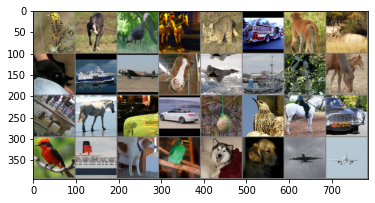

In [ ]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2. + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
#images, labels = train_data_iter.next()
images, labels = reference_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))
#print(images)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Display Noise functions on images

32
torch.Size([3, 96, 96])
 bird   dog  bird horse


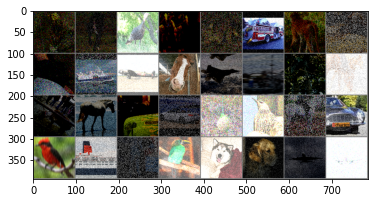

In [ ]:
print(len(images[:]))
print(images[0].shape)
#print(images[0])
MM = copy.deepcopy(images)
MM = add_noise_to_images(MM,0.25,0.25,0.10,0.5,0.5)
# show images
imshow(torchvision.utils.make_grid(MM))
#print(images)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Original Image


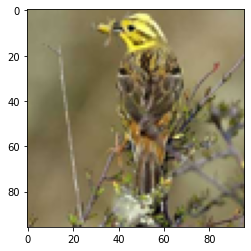

In [ ]:
print("Original Image")
imshow(images[0])

Image with Gaussian noise


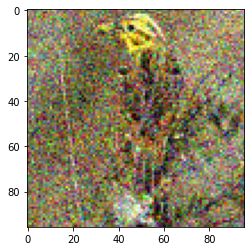

In [ ]:
print("Image with Gaussian noise")
imshow(gaussian_noise(images[0],0.3))

Image with underexposure


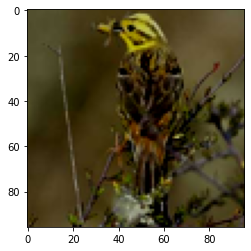

In [ ]:
print("Image with underexposure")
imshow(underexposure(images[0],0.5))

Image with overexposure


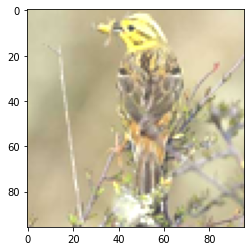

In [ ]:
print("Image with overexposure")
imshow(overexposure(images[0],0.5))

Image with salt and pepper noise


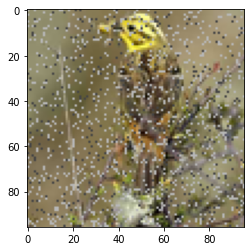

In [ ]:
print("Image with salt and pepper noise")
imshow(salt_and_pepper_noise(images[0],0.1,0.05))

Image with motion blur


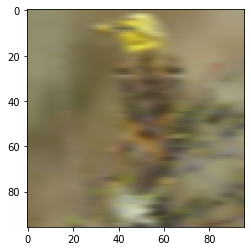

In [ ]:
print("Image with motion blur")
imshow(motion_blur(images[0],3, 0.5))

 bird   dog  bird horse


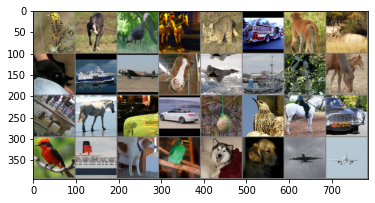

In [ ]:
# Used in order to check that the images variable has not been overwritten
imshow(torchvision.utils.make_grid(images))
#print(images)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## New libraries for learning

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [ ]:
print(np.sqrt(2))

1.4142135623730951


## Network structure

In [ ]:
# Image dimensions
channels = x.shape[1]
height = x.shape[2]
width = x.shape[3]
num_features = (height * width) * channels

def compute_conv_dim(dim_size,kernel_size,padding_size,stride_size):
    return int((dim_size - kernel_size + 2 * padding_size) / stride_size + 1)

# First convolution layer
num_filters_conv1 = 16
kernel_size_conv1 = 5 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1 = 2
input_dim = 32

# Second convolution layer
num_filters_conv2 = 5
kernel_size_conv2 = 5
stride_conv2 = 1
padding_conv2 = 1

# Convolutional layers
filters = [32,64,128,256,256]
kernels = [3,3,3,3,3]
padding = [1,1,1,1,1]
strides = [2,2,2,2,1]

# Hidden nodes in linear layers in Encoder
h1e = 2000
h2e = 1875

# Hidden nodes in linear layers in Decoder 
h1d = 2352
h2d = 1000

class AutoEncoder(nn.Module):
    def __init__(self, latent_features=2):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.
        
        # Dropout
        self.dropout = nn.Dropout2d(p=0.3)

        ############################
        # Encoder (downsampling)   #
        ############################
        self.enc_conv0 = Conv2d(3, 32, 3, stride=2, padding=1)
        #torch.nn.init.xavier_normal_(self.enc_conv0.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.enc_conv0.weight, mode='fan_in', nonlinearity='relu')
        #self.pool0 = nn.MaxPoold(3, 2, padding=1)  # 256 -> 128
        self.enc_norm0 = nn.BatchNorm2d(32)

        self.enc_conv1 = Conv2d(32, 64, 3, stride=2, padding=1)
        #self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        #torch.nn.init.xavier_normal_(self.enc_conv1.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.enc_conv1.weight, mode='fan_in', nonlinearity='relu')
        self.enc_norm1 = nn.BatchNorm2d(64)

        self.enc_conv2 = Conv2d(64, 128, 3, stride=2, padding=1)
        #self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        #torch.nn.init.xavier_normal_(self.enc_conv2.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.enc_conv2.weight, mode='fan_in', nonlinearity='relu')
        self.enc_norm2 = nn.BatchNorm2d(128)

        self.enc_conv3 = Conv2d(128, 256, 3, stride=2, padding=1)
        #self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        #torch.nn.init.xavier_normal_(self.enc_conv3.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.enc_conv3.weight, mode='fan_in', nonlinearity='relu')
        self.enc_norm3 = nn.BatchNorm2d(256)

        self.enc_conv4 = Conv2d(256, 512, 3, stride=2, padding=1)
        # self.pool4 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16
        #torch.nn.init.xavier_normal_(self.enc_conv4.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.enc_conv4.weight, mode='fan_in', nonlinearity='relu')
        self.enc_norm4 = nn.BatchNorm2d(512)


        # bottleneck
        self.bottleneck_conv = Conv2d(512, 512, 3, stride=1, padding=1)
        #torch.nn.init.xavier_normal_(self.bottleneck_conv.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.bottleneck_conv.weight, mode='fan_in', nonlinearity='relu')
        self.norm_bottleneck = nn.BatchNorm2d(512)

        ############################
        # Decoder (UPsampling)     #
        ############################
        self.dec_conv0 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.xavier_normal_(self.dec_conv0.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.dec_conv0.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm0 = nn.BatchNorm2d(512)

        self.dec_conv1 = nn.ConvTranspose2d(512+256, 256, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.xavier_normal_(self.dec_conv1.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.dec_conv1.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm1 = nn.BatchNorm2d(256)

        self.dec_conv2 = nn.ConvTranspose2d(256+128, 128, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.xavier_normal_(self.dec_conv2.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.dec_conv2.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm2 = nn.BatchNorm2d(128)

        self.dec_conv3 = nn.ConvTranspose2d(128+64, 64, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.xavier_normal_(self.dec_conv3.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.dec_conv3.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm3 = nn.BatchNorm2d(64)

        self.dec_conv4 = nn.ConvTranspose2d(64+32, 32, 3, stride=2, padding=1, output_padding=1)
        #torch.nn.init.xavier_normal_(self.dec_conv4.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.dec_conv4.weight, mode='fan_in', nonlinearity='relu')
        self.dec_norm4 = nn.BatchNorm2d(32)

        self.final_deconv = nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1, output_padding=0)
        #torch.nn.init.xavier_normal_(self.final_deconv.weight,gain=np.sqrt(2.0))
        torch.nn.init.kaiming_normal_(self.final_deconv.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer

        # encoder
        e0 = F.relu(self.enc_norm0(self.enc_conv0(x)))
        #e0 = self.dropout(e0)
        e1 = F.relu(self.enc_norm1(self.enc_conv1(e0)))
        #e1 = self.dropout(e1)
        e2 = F.relu(self.enc_norm2(self.enc_conv2(e1)))
        #e2 = self.dropout(e2)
        e3 = F.relu(self.enc_norm3(self.enc_conv3(e2)))
        #e3 = self.dropout(e3)
        e4 = F.relu(self.enc_norm4(self.enc_conv4(e3)))
        #e4 = self.dropout(e4)

        # bottleneck
        b = F.relu(self.norm_bottleneck(self.bottleneck_conv(e4)))
        z = b

        # decoder
        d0 = F.relu(self.dec_norm0(self.dec_conv0(b)))
        #d0 = self.dropout(d0)
        skip0 = torch.cat([d0, e3], 1)
        d1 = F.relu(self.dec_norm1(self.dec_conv1(skip0)))
        #d1 = self.dropout(d1)
        skip1 = torch.cat([d1, e2], 1)
        d2 = F.relu(self.dec_norm2(self.dec_conv2(skip1)))
        #d2 = self.dropout(d2)
        skip2 = torch.cat([d2, e1], 1)
        d3 = F.relu(self.dec_norm3(self.dec_conv3(skip2)))
        #d3 = self.dropout(d3)
        skip3 = torch.cat([d3, e0], 1)
        d4 = self.dec_conv4(skip3)  # no activation, no batch normalization

        x_hat = self.final_deconv(d4)
        return {
            'z': z,
            'x_hat': x_hat
        }


# Choose the shape of the autoencoder
net = AutoEncoder(latent_features=1875)

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (dropout): Dropout2d(p=0.3, inplace=False)
  (enc_conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck_conv): Conv2d(512, 512, kernel_size=(3, 3

## Loss functions and optimizers

In [ ]:
#import torch.optim as optim

# if you want L2 regularization, then add weight_decay to SGD
#optimizer = optim.SGD(net.parameters(), lr=0.08, momentum = 0.5)
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-5) # Change by TC - 22.11.2021
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
#loss_function = nn.CrossEntropyLoss()

## Test of one forward pass

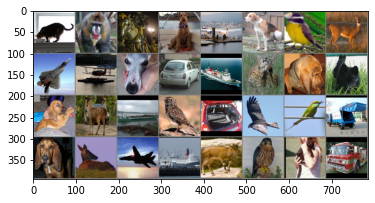

In [ ]:
# test the forward pass
# expect output size of [32, num_features]
x, y = next(iter(trainloader))
imshow(torchvision.utils.make_grid(x))

In [ ]:
if cuda:
    x = x.cuda()

outputs = net(x)
print(f"x.shape = {x.shape}")
print(f"x_hat.shape = {outputs['x_hat'].shape}")
print(f"z.shape = {outputs['z'].shape}")
print(type(x))
x_hat = outputs['x_hat']
print(type(x_hat))

x.shape = torch.Size([32, 3, 96, 96])
x_hat.shape = torch.Size([32, 3, 96, 96])
z.shape = torch.Size([32, 512, 3, 3])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


## Train Network

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 120

train_loss = []
valid_loss = []
counter = 0
for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in trainloader:
        
        # Make a copy, so we do not overwrite the old data
        x_noisy = copy.deepcopy(x)
        x_noisy = add_noise_to_images(x_noisy,0.1,0.1,0.1,0.3,0.3)
        
        if cuda:
            x_noisy = x_noisy.cuda()
            x = x.cuda()

        #if counter == 156:
        #    print("STOP")
        outputs = net(x_noisy)
        x_hat = outputs['x_hat']

        # note, target is the original tensor, as we're working with auto-encoders
        #loss = loss_function(x_hat, x.view(-1, width*height*channels)) # TC: Changes this
        loss = loss_function(x_hat, x)  #

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        #counter = counter + 1
        #print("Counter", counter)

    #scheduler.step()
    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(testloader))
        
        x_noisy = copy.deepcopy(x)
        x_noisy = add_noise_to_images(x_noisy,0.1,0.1,0.1,0.3,0.3)
        
        if cuda:
            x_noisy = x_noisy.cuda()
            x = x.cuda()
        
        outputs = net(x_noisy)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x_hat = outputs['x_hat']
        z = outputs['z'].cpu().numpy()

        #loss = loss_function(x_hat, x.view(batch_size, width*height*channels))
        loss = loss_function(x_hat, x)

        valid_loss.append(loss.item())
    
    if epoch == 0:
        continue

    print("Epoch", epoch, "/", num_epochs)
# live plotting of the trainig curves and representation

Epoch 1 / 120
Epoch 2 / 120
Epoch 3 / 120
Epoch 4 / 120
Epoch 5 / 120
Epoch 6 / 120
Epoch 7 / 120
Epoch 8 / 120
Epoch 9 / 120
Epoch 10 / 120
Epoch 11 / 120
Epoch 12 / 120
Epoch 13 / 120
Epoch 14 / 120
Epoch 15 / 120
Epoch 16 / 120
Epoch 17 / 120
Epoch 18 / 120
Epoch 19 / 120
Epoch 20 / 120
Epoch 21 / 120
Epoch 22 / 120
Epoch 23 / 120
Epoch 24 / 120
Epoch 25 / 120
Epoch 26 / 120
Epoch 27 / 120
Epoch 28 / 120
Epoch 29 / 120
Epoch 30 / 120
Epoch 31 / 120
Epoch 32 / 120
Epoch 33 / 120
Epoch 34 / 120
Epoch 35 / 120
Epoch 36 / 120
Epoch 37 / 120
Epoch 38 / 120
Epoch 39 / 120
Epoch 40 / 120
Epoch 41 / 120
Epoch 42 / 120
Epoch 43 / 120
Epoch 44 / 120
Epoch 45 / 120
Epoch 46 / 120
Epoch 47 / 120
Epoch 48 / 120
Epoch 49 / 120
Epoch 50 / 120
Epoch 51 / 120
Epoch 52 / 120
Epoch 53 / 120
Epoch 54 / 120
Epoch 55 / 120
Epoch 56 / 120
Epoch 57 / 120
Epoch 58 / 120
Epoch 59 / 120
Epoch 60 / 120
Epoch 61 / 120
Epoch 62 / 120
Epoch 63 / 120
Epoch 64 / 120
Epoch 65 / 120
Epoch 66 / 120
Epoch 67 / 120
Epoc

## Plot Errors

Train loss in last epoch = -42317565566.976
Test loss in last epoch = -43261091840.0


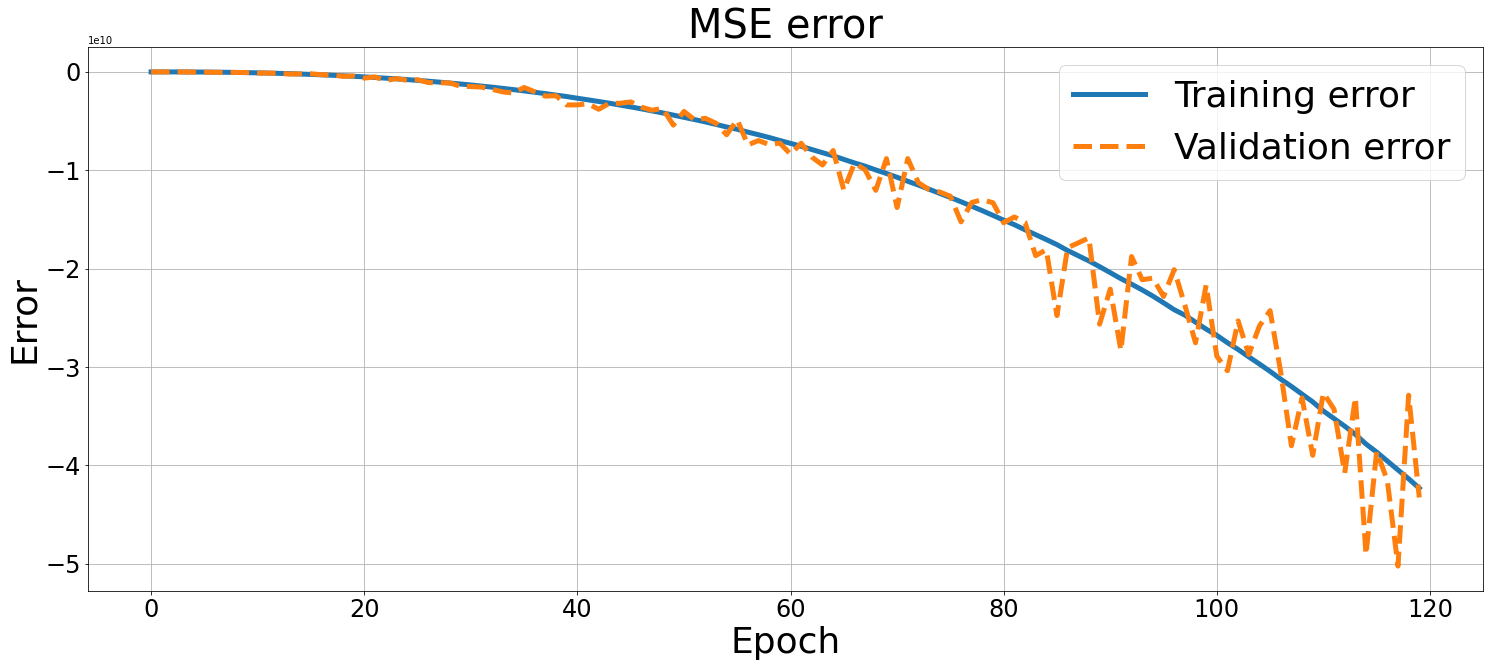

In [ ]:
# plot_autoencoder_stats(x=x.view(batch_size, width*height*channels),
#                         x_hat=x_hat.view(batch_size, width*height*channels),
#                         z=z,
#                         y=y,
#                         train_loss=train_loss,
#                         valid_loss=valid_loss,
#                         epoch=epoch,
#                         classes=classes,
#                         dimensionality_reduction_op=None)

csfont = {'fontname':'Arial'}

plt.figure(figsize=(25, 10))
x_axis_epoch = np.arange(epoch+1)
plt.plot(x_axis_epoch,train_loss, linewidth=5,label='Training error')
plt.plot(x_axis_epoch,valid_loss,'--',linewidth=5,label='Validation error')
plt.xlabel('Epoch',fontsize=36,**csfont)
plt.ylabel('Error',fontsize=36,**csfont)
plt.title('MSE error',fontsize=40,**csfont)
plt.legend(loc="upper right", fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid()
plt.savefig('drive/My Drive/ColabNotebooks/figures/graph.png',transparent=True)

print("Train loss in last epoch =", train_loss[-1])
print("Test loss in last epoch =", valid_loss[-1])


save_to = 2
if save_to == 1:
    with open('train_loss1.pickle', 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('valid_loss1.pickle', 'wb') as handle:
        pickle.dump(valid_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
elif save_to == 2:
    with open('train_loss2.pickle', 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('valid_loss2.pickle', 'wb') as handle:
        pickle.dump(valid_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
elif save_to == 3:
    with open('train_loss3.pickle', 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('valid_loss3.pickle', 'wb') as handle:
        pickle.dump(valid_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
elif save_to == 4:
    with open('train_loss4.pickle', 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('valid_loss4.pickle', 'wb') as handle:
        pickle.dump(valid_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
elif save_to == 5:
    with open('train_loss5.pickle', 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('valid_loss5.pickle', 'wb') as handle:
        pickle.dump(valid_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    pass

## Plot images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


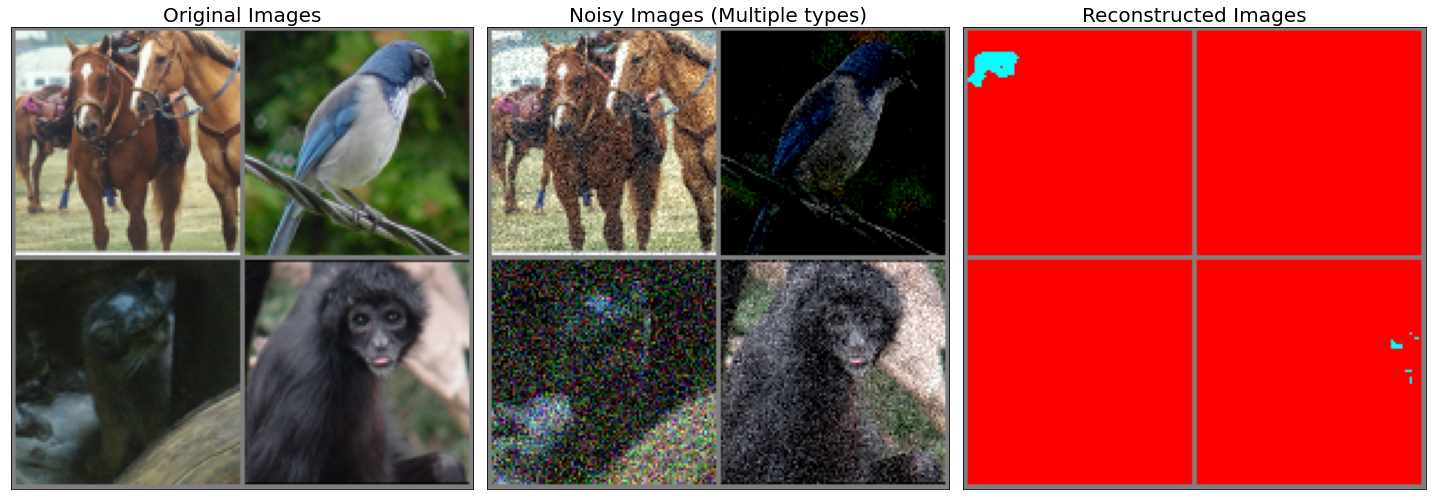

In [ ]:
def unnormalize_image(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Pass batch through network
x, y = reference_data_iter.next()
x_noisy = copy.deepcopy(x)
x_noisy = add_noise_to_images(x_noisy, 0.1, 0.1, 0.1, 0.3, 0.3)
if cuda:
    x_noisy = x_noisy.cuda()
    x = x.cuda()
outputs = net(x_noisy)
x_hat = outputs['x_hat']

# Create plot of image reconstructions
f, axarr = plt.subplots(1, 3, figsize=(20, 20))
# remove the x and y ticks
for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])

ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[9:13].cpu(), nrow=2)
ax.imshow(unnormalize_image(x_grid))
ax.set_title("Original Images", size=20)

ax = axarr[1]
x_noisy_grid = torchvision.utils.make_grid(x_noisy[9:13].cpu(), nrow=2)
ax.imshow(unnormalize_image(x_noisy_grid))
ax.set_title("Noisy Images (Multiple types)", size=20)

ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[9:13].cpu(), nrow=2)
#x_hat_grid = torchvision.utils.make_grid(x_hat_rgb)
ax.imshow(unnormalize_image(x_hat_grid))
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/MultipleNoise.png',transparent=True) # Run this two times to get good results

## Gaussian noise added to images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


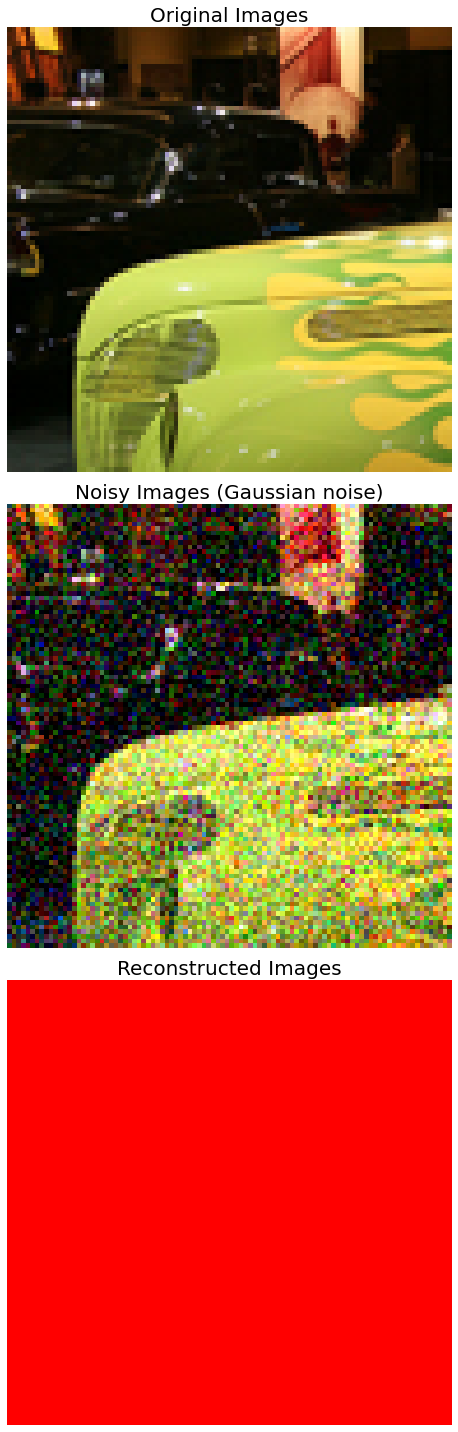

In [ ]:
img_number = 18
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 1)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Gaussian noise)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/GaussianNoise.png',transparent=True) # Run this two times to get good results

## Salt and Pepper Noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


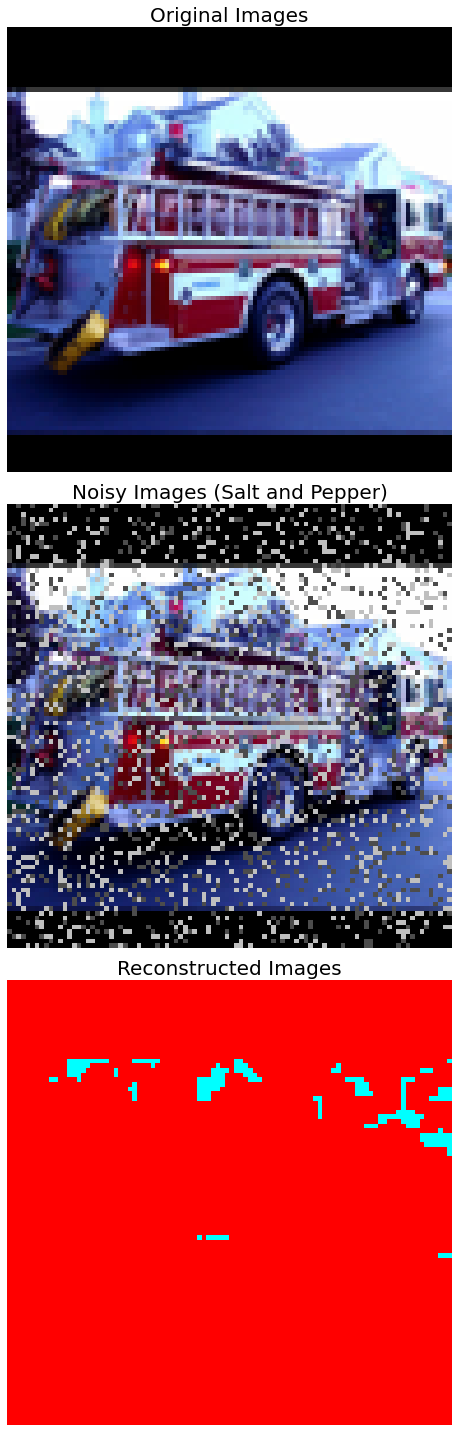

In [ ]:
img_number = 5 # Used for comparison between networks
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 2)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Salt and Pepper)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/SaltPepper.png',transparent=True)

## Gaussian Grain

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


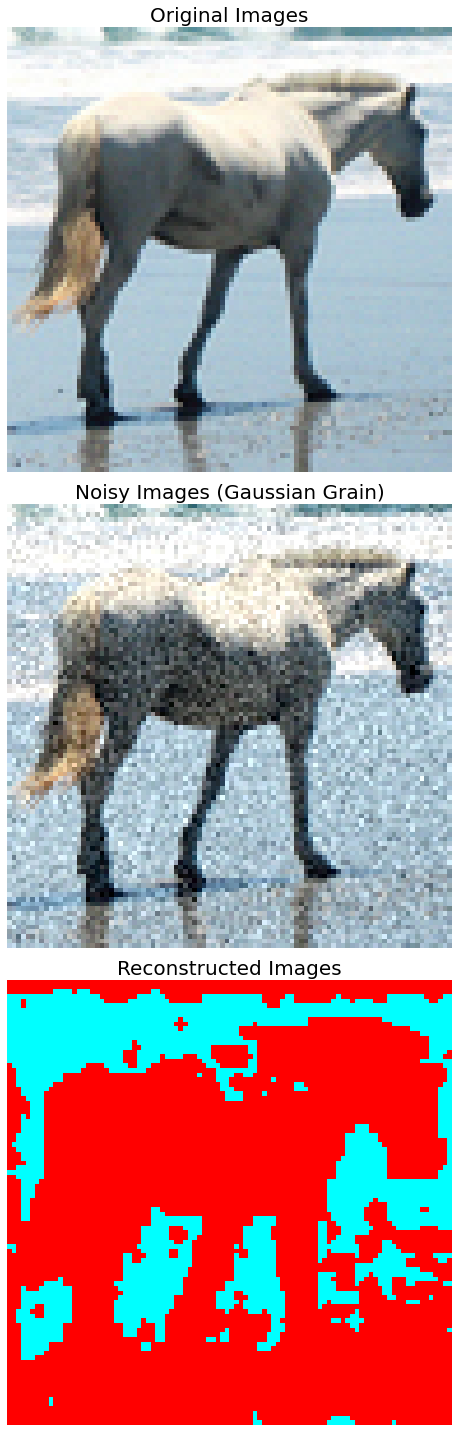

In [ ]:
img_number = 17
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 3)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Gaussian Grain)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/GaussianGrain.png',transparent=True)

## Underexposure added to the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


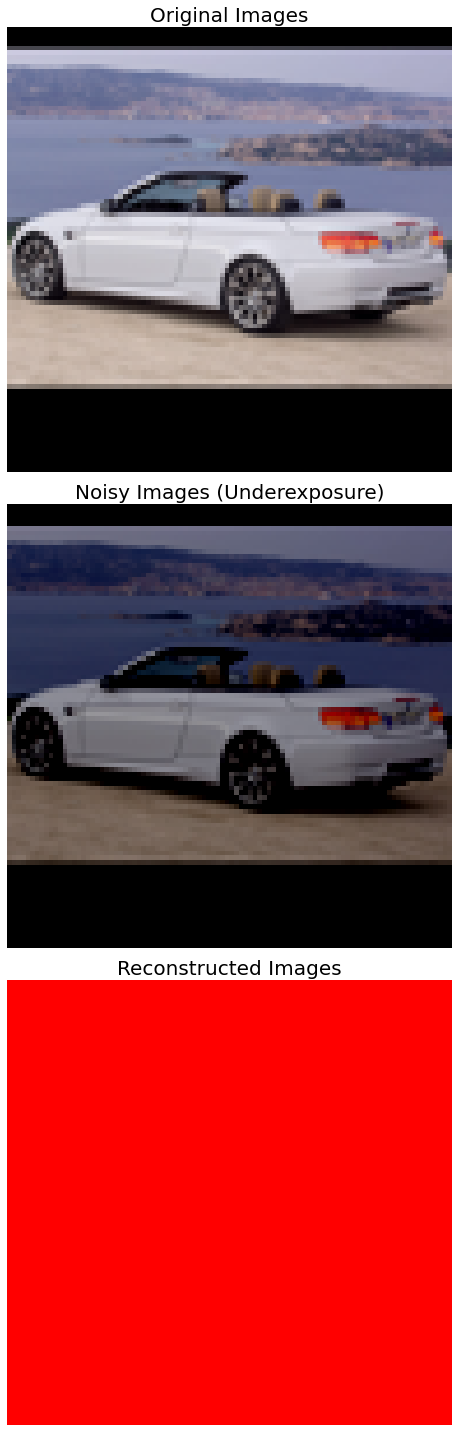

In [ ]:
img_number = 19
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 4)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Underexposure)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/UnderExposure.png',transparent=True)

## Overexposure

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


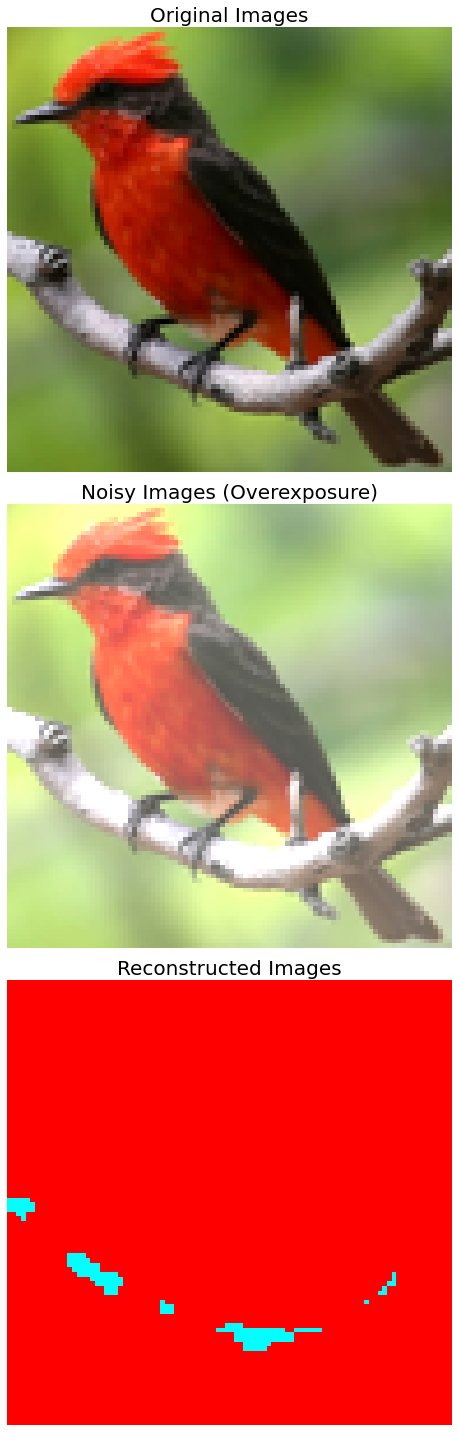

In [ ]:
img_number = 24
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 5)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Overexposure)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/OverExposure.png',transparent=True)

## Motion blur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done with script


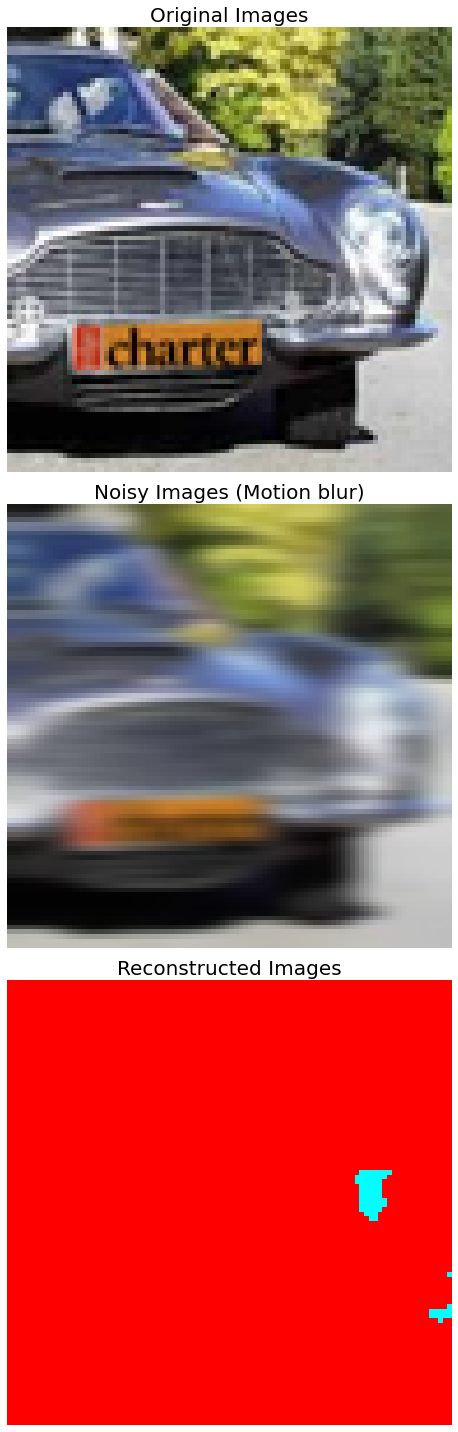

In [ ]:
img_number = 23
x, y = next(iter(referenceloader))
test_img = copy.deepcopy(x)
test_img = test_noise_on_images(test_img, 6)
if cuda:
    test_img = test_img.cuda()
    x = x.cuda()
outputs = net(test_img)
x_hat = outputs['x_hat']
f, axarr = plt.subplots(3, 1, figsize=(20, 20))
ax = axarr[0]
x_grid = torchvision.utils.make_grid(x[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Original Images", size=20)
ax = axarr[1]
x_grid = torchvision.utils.make_grid(test_img[img_number].cpu())
ax.imshow(unnormalize_image(x_grid))
ax.axis('off')
ax.set_title("Noisy Images (Motion blur)", size=20)
ax = axarr[2]
x_hat_grid = torchvision.utils.make_grid(x_hat[img_number].cpu().detach())
ax.imshow(unnormalize_image(x_hat_grid))
ax.axis('off')
ax.set_title("Reconstructed Images", size=20)
f.tight_layout()
plt.savefig('drive/My Drive/ColabNotebooks/figures/MotionBlur.png',transparent=True)
print("Done with script")